In [20]:
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns

In [37]:
station_id = '23025122'
meses = range(1,13)
data_names = ['tempsolocm40cm', 'tempsolocm40cm_diff']

Funções de fitness das operações

In [22]:
# Funções de Fitness
def calc_smaller(a: float, b: float):
	return b - a
def calc_greater(a: float, b: float):
	return a - b
def calc_smaller_or_equal(a: float, b: float):
	return b - a + 1
def calc_greater_or_equal(a: float, b: float):
	return a - b + 1
def calc_equal(a: float, b: float):
	return -abs(a - b)
def calc_and(a: float, b: float):
	return min(a, b)
def calc_or(a: float, b: float):
	return max(a, b)
def calc_not(a: float):
	return -a

Função que roda o programa em java

In [23]:
def run_stl(stl_input, grammar='grammar_idr.bnf', seed=1337, tournament_size=5, n_iterations=50):
  stl_cmd = 'java -Dfile.encoding=UTF-8 -classpath "./target/classes;./libs/JGEA.jar;./libs/moonlight.jar;./libs/jblas-1.2.4.jar" it.units.malelab.learningstl.Main seed={} grammar=./grammars/{} local_search=false input={} tournament_size={} number_iterations={}'.format(seed, grammar, stl_input, tournament_size, n_iterations)
  print(stl_cmd)
  return os.system(stl_cmd)

In [24]:
def plot(vals, labels=None, detected_anomalies=[], continuous_anomalies=[], margins=None, title='', save=False, img_name=None, show=True, divisions=[], sec_plots=[]):
	X=range(len(vals))
	max_y, min_y = max(vals), min(vals)
	fig, ax = plt.subplots(figsize=(20, 6), dpi=720)
	ax.set_title(title)
	plt.plot(vals)
	if labels:
		plt.xticks([label[0] for label in labels], [label[1] for label in labels], rotation=45)
	for subplot in sec_plots:
		plt.plot(subplot)
	for i in detected_anomalies:
		plt.scatter(i, vals[i], s=800, marker="x", color="r", alpha=0.6)
	anom_dev = max_y - min_y
	for i in continuous_anomalies:
		anom_top_margins = []
		anom_bottom_margins = []
		for point in range(i[0], i[1]):
			anom_top_margins.append(vals[point]+anom_dev)
			anom_bottom_margins.append(vals[point]-anom_dev)
		plt.fill_between(range(i[0], i[1]), anom_top_margins, anom_bottom_margins, alpha = 0.7, color="r", interpolate=True)
	plt.fill_between(
		[i for i in range(len(vals))],
		[max_y for i in range(len(vals))],
		[min_y for i in range(len(vals))],
		where=[True if i in divisions else False for i in range(len(vals))],
		color='grey', linestyle='--', alpha=0.5
	)
	j = 0
	if margins:
		for margin in margins:
			plt.fill_between(range(len(vals)), margin[0], margin[1], alpha = 0.1, color="b")
	fig.tight_layout()
	if save:
		fig.savefig(img_name if img_name is not None else title, bbox_inches='tight')
	if show:	
 		plt.show()
	else:
		plt.close(fig)
	

In [25]:
# full_temp = full_data['tempsolocm40cm'].to_list()
# divisions = [i for i, d in enumerate(full_data['date']) if i == 0 or d.split('-')[1] != full_data['date'][i-1].split('-')[1]]

# labels = [(i, d) for i, d in enumerate(full_data['date']) if i == 0 or (d.split('-')[1] != full_data['date'][i-1].split('-')[1] and (d.split('-')[1] == '06' or d.split('-')[1] == '01'))]

# plot(full_temp, title='Full Temperature', divisions=divisions, labels=labels, save=True, img_name='full_temp.jpg')

# plot([x for x in full_temp if x < 35 and x > 8], title='Full Temperature, curated', divisions=divisions, labels=labels, save=True, img_name='full_temp_curated.jpg')

# for i, season in enumerate(['Summer', 'Autumn', 'Winter', 'Spring']):
# 	data = pd.read_csv('data/seasons/tempsolocm40cm/tempsolocm40cm.{}.dia_id.season_{}.csv'.format(station_id, i))
# 	temp = data['tempsolocm40cm'].to_list()
# 	meses = data['month'].to_list()

# 	labels=[(i, month) for i, month in enumerate(meses) if i == 0 or meses[i] != meses[i-1]]

# 	plot([x for x in temp if x < 35 and x > 8],
# 			divisions=[label[0] for label in labels],
# 			labels=labels,
# 			title='Temperature by Month - {}'.format(season), save=True, img_name='temp_{}.jpg'.format(season))

In [44]:
def unnormalize(val, min_val, max_val):
	return (val * (max_val - min_val)) + min_val
def unnormalize_string(min_maxes):
	def f(match_group):
		if match_group[1][0] == 'H':
			min_val = 0
			max_val = 1
		elif match_group[1] == 'hour':
			min_val = 0
			max_val = 23
		else:
			min_val = min_maxes[match_group[1]][0]
			max_val = min_maxes[match_group[1]][1]

		return '{} {} {}'.format(match_group[1], match_group[2], unnormalize(float(match_group[3]), min_val, max_val))
	return f

Função que parseia e avalia uma regra

In [27]:
def parse_rule(rule: str):
	regex_search = re.search(r'AND|NOT|OR', rule)
	if not regex_search:
		# É operador simples
		var, comp, val = re.search(r'([a-zA-Z0-9]*) ([<>=]*) ([0-9\.]*)', rule).groups()
		val = float(val)
		def comp_func(line):
			if comp == '>':
				# if not line[var] > val:
				# 	print('{} ({}) é <= {}'.format(var, line[var], val))
				return calc_greater(line[var], val)
			elif comp == '<':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller(line[var], val)
			elif comp == '<=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_smaller_or_equal(line[var], val)
			elif comp == '>=':
				# if not line[var] < val:
				# 	print('{} ({}) é >= {}'.format(var, line[var], val))
				return calc_greater_or_equal(line[var], val)
			else:
				# if not line[var] == val:
				# 	print('{} ({}) é != {}'.format(var, line[var], val))
				return calc_equal(line[var], val)
		return comp_func
	sub_rule = rule[regex_search.span()[1]+1:-1]
	if regex_search[0] == 'AND':
		count = 0
		sub_rule_1 = 'nada'
		sub_rule_2 = 'nada'
		for i, l in enumerate(sub_rule):
			if l == '[':
				count+=1
			if l == ']':
				count-=1
			if l == ';' and count == 0:
				sub_rule_1 = sub_rule[:i]
				sub_rule_2 = sub_rule[i+1:]
				sub_rule_func_1 = parse_rule(sub_rule_1)
				sub_rule_func_2 = parse_rule(sub_rule_2)
				def and_function(line):
					res_func_1 = sub_rule_func_1(line)
					res_func_2 = sub_rule_func_2(line)
					# if not (res_func_1 and res_func_2):
					# 	print('{} é falso porque'.format(sub_rule))
					# if not res_func_1:
					# 	print('{} é falso'.format(sub_rule_1))
					# if not res_func_2:
					# 	print('{} é falso'.format(sub_rule_2))
					return calc_and(res_func_1, res_func_2)
				return and_function
	if regex_search[0] == 'OR':
		count = 0
		sub_rule_1 = 'nada'
		sub_rule_2 = 'nada'
		for i, l in enumerate(sub_rule):
			if l == '[':
				count+=1
			if l == ']':
				count-=1
			if l == ';' and count == 0:
				sub_rule_1 = sub_rule[:i]
				sub_rule_2 = sub_rule[i+1:]
				sub_rule_func_1 = parse_rule(sub_rule_1)
				sub_rule_func_2 = parse_rule(sub_rule_2)
				def or_function(line):
					res_func_1 = sub_rule_func_1(line)
					res_func_2 = sub_rule_func_2(line)
					# if not (res_func_1 and res_func_2):
					# 	print('{} é falso porque'.format(sub_rule))
					# if not res_func_1:
					# 	print('{} é falso'.format(sub_rule_1))
					# if not res_func_2:
					# 	print('{} é falso'.format(sub_rule_2))
					return calc_or(res_func_1, res_func_2)
				return or_function
	if regex_search[0] == 'NOT':
		sub_rule_func = parse_rule(sub_rule)
		def not_funcion(line):
			res_func = sub_rule_func(line)
			# if res_func:
			# 	print('{} é verdadeiro'.format(sub_rule))
			return -res_func
		return not_funcion

In [28]:
# Função que cria as ranges
def sep_anomalies(anomalies):
	anom_start = -1
	continuous_anomalies = []
	for i, anomaly in enumerate(anomalies):
		# Se o próximo for anomalia
		if i < (len(anomalies) - 1) and anomalies[i+1] == anomaly+1:
			# E o anterior não for ou for o primeiro da lista
			if anomalies[i-1] != anomaly-1 or i == 0:
				# É começo de uma contínua
				anom_start = anomaly
		# Se o anterior é anomalia e o próximo não for ou for o fim da lista, é fim de contínuo
		elif i > 0 and anomalies[i-1] == anomaly-1:
			continuous_anomalies.append((anom_start, anomaly))
			anom_start = -1
		# Se o próximo e o anterior não forem anomalia, é isolado
		else:
			continuous_anomalies.append((anomaly, anomaly))
	return continuous_anomalies

In [29]:
# parser_mes1 = parse_rule(regra_mes1)
# parser_mes2 = parse_rule(regra_mes2)

In [30]:
# sum_rob = 0
# for i, r in mes1.iterrows():
# 	rob = parser_mes1(r)
# 	sum_rob += rob
# 	if rob >= 0:
# 		print(i)
# print(sum_rob)

Gerando regras e limpando saída

In [31]:
img_name = 'tempsolocm40cm.{}.dia_id.season_0'.format(station_id)
series_name = 'tempsolocm40cm.{}.dia_id.season_0.csv'.format(station_id)
# grammar = 'grammar_idr_sem_hora.bnf'
grammar = 'grammar_idr_sem_hora_simples.bnf'
series_file = './data/seasons/tempsolocm40cm/{}'.format(series_name)
output_file = './output/{}'.format(series_name)

In [43]:
for season in range(4):
	file_n = 'tempsolocm40cm.23025122.dia_id.season_{}.diff'.format(season)
	stl_run = run_stl('./data/seasons/tempsolocm40cm/{}.csv'.format(file_n), seed=123456, n_iterations=50, tournament_size=8, grammar=grammar)
	print(stl_run)
	if stl_run != 0:
		print('{}.csv'.format(file_n), grammar)
	else:
		series = pd.read_csv('./data/seasons/tempsolocm40cm/{}.csv'.format(file_n))

		# Limpando headers adicionais
		with open('./output/{}.csv'.format(file_n), 'r') as f:
			lines = f.readlines()
		with open('./output/{}.csv'.format(file_n), 'w') as f:
			for i, line in enumerate(lines):
				if i == 0 or not line.startswith('iterations,births,fitness.evaluations'):
						f.write(line)

		output = pd.read_csv('./output/{}.csv'.format(file_n))

		# Desnormalizando a saída
		min_max = {
			# 'month': (min(series['month']), max(series['month'])),
		}

		for feature in data_names:
			min_max[feature] = (min(series[feature]), max(series[feature]))

		output['serialized'] = [re.sub(r'([a-zA-Z0-9_]*) ([<>=]*) ([0-9\.]*)', unnormalize_string(min_max), rule) for rule in output['serialized']]
		output.to_csv('./output/{}.csv'.format(file_n), index=0)

java -Dfile.encoding=UTF-8 -classpath "./target/classes;./libs/JGEA.jar;./libs/moonlight.jar;./libs/jblas-1.2.4.jar" it.units.malelab.learningstl.Main seed=123456 grammar=./grammars/grammar_idr_sem_hora_simples.bnf local_search=false input=./data/seasons/tempsolocm40cm/tempsolocm40cm.23025122.dia_id.season_0.diff.csv tournament_size=8 number_iterations=50
0
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff < 0.6970000000000001'>
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff > 0.6990000000000001'>
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff > 0.6980000000000001'>
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff > 0.6980000000000001'>
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff > 0.6980000000000001'>
tempsolocm40cm_diff
<re.Match object; span=(0, 40), match='tempsolocm40cm_diff < 0.6980000000000001'>
tempsolocm40cm_diff
<re.Matc

In [54]:
for i, season in enumerate(['Summer', 'Autumn', 'Winter', 'Spring']):
	file_n = 'tempsolocm40cm.23025122.dia_id.season_{}'.format(i)
	regra = pd.read_csv('./output/{}.csv'.format(file_n))['serialized'].to_list()[-1]
	print(regra, '\n')

AND[NOT[HISTORICALLY I=[43; 84][tempsolocm40cm < 25.31988]];HISTORICALLY I=[91; 145][tempsolocm40cm > 26.70978]] 

NOT[HISTORICALLY I=[25; 77][HISTORICALLY I=[8; 13][tempsolocm40cm < 23.89716]]] 

AND[HISTORICALLY I=[56; 116][HISTORICALLY I=[75; 133][tempsolocm40cm < 1819.4417500000002]];AND[HISTORICALLY I=[57; 124][tempsolocm40cm < 1674.47];HISTORICALLY I=[43; 126][tempsolocm40cm > 1691.4147500000001]]] 

HISTORICALLY I=[85; 163][tempsolocm40cm < 11.022860000000001] 



In [45]:
for i, season in enumerate(['Summer', 'Autumn', 'Winter', 'Spring']):
	file_n = 'tempsolocm40cm.23025122.dia_id.season_{}.diff'.format(i)
	regra = pd.read_csv('./output/{}.csv'.format(file_n))['serialized'].to_list()[-1]
	f_rule = parse_rule(regra)
	prev_val = 0
	aplies = []
	range_tuple = tuple()
	for val in np.arange(0, 50, 0.01):
		new_val = f_rule({'tempsolocm40cm': val})
		if val == 0 and new_val >= 0:
			range_tuple = (0,)
			prev_val = new_val
			continue
		if prev_val * new_val < 0:
			if new_val < 0:
				range_tuple += (val - 0.01,)
				aplies.append(range_tuple)
			else:
				range_tuple = (val,)
		prev_val = new_val

	stl_input = pd.read_csv('./data/seasons/tempsolocm40cm/{}.csv'.format(file_n))

	temp = stl_input['tempsolocm40cm'].to_list()
	meses = stl_input['month'].to_list()

	labels=[(i, month) for i, month in enumerate(meses) if i == 0 or meses[i] != meses[i-1]]

	print(regra)

	plot([x for x in temp if x < 35 and x > 8],
			margins=aplies,
			divisions=[label[0] for label in labels],
			labels=labels,
			title='Temperature by Month - Applying Rule - {}'.format(season), save=True, img_name='temp_{}_rule.jpg'.format(season))

ValueError: could not convert string to float: ''

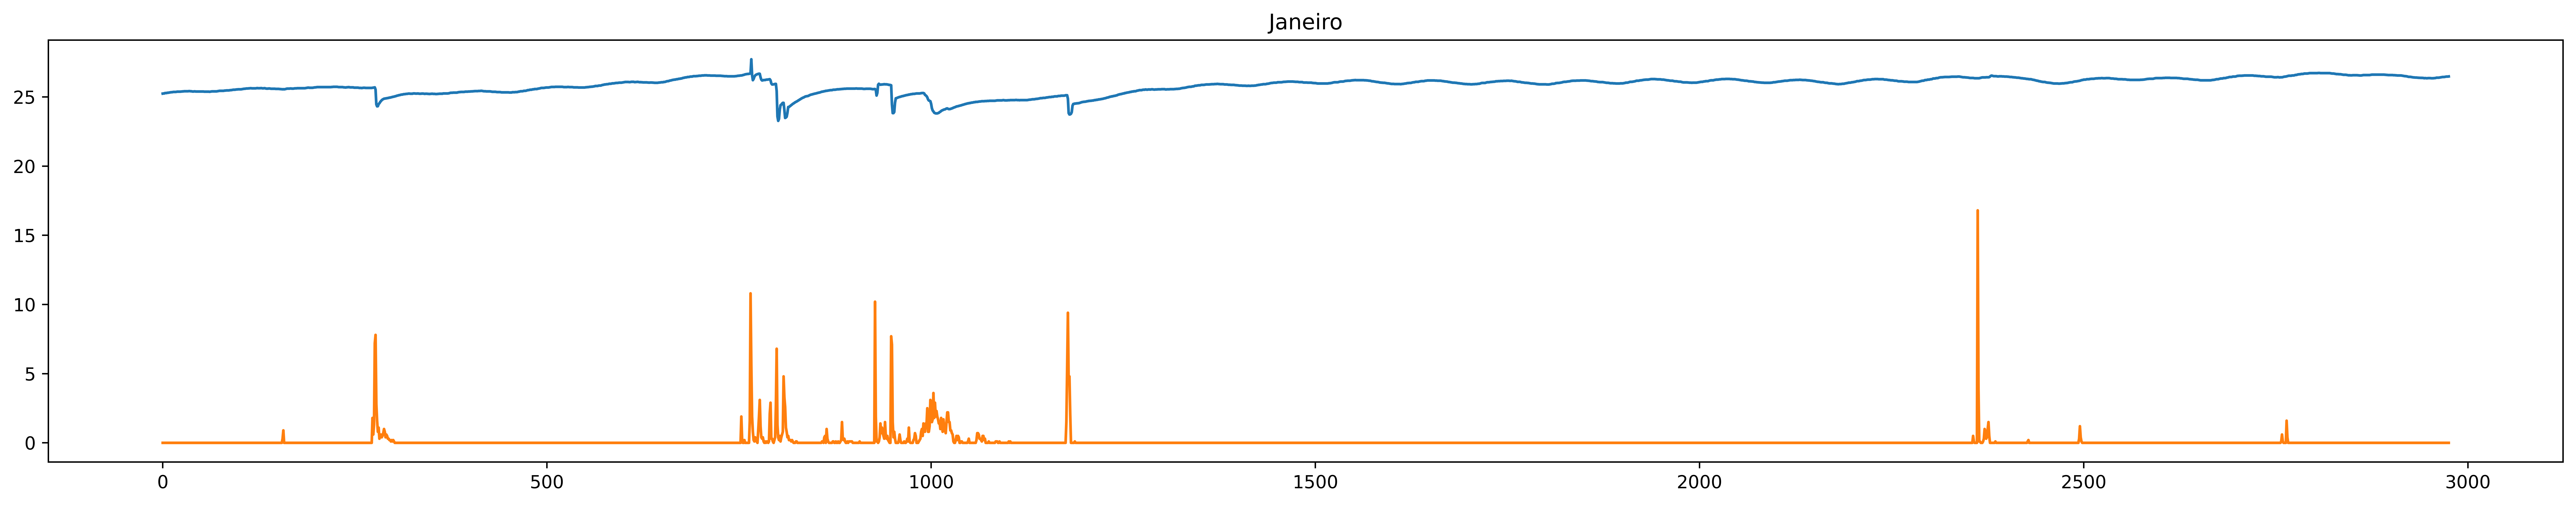

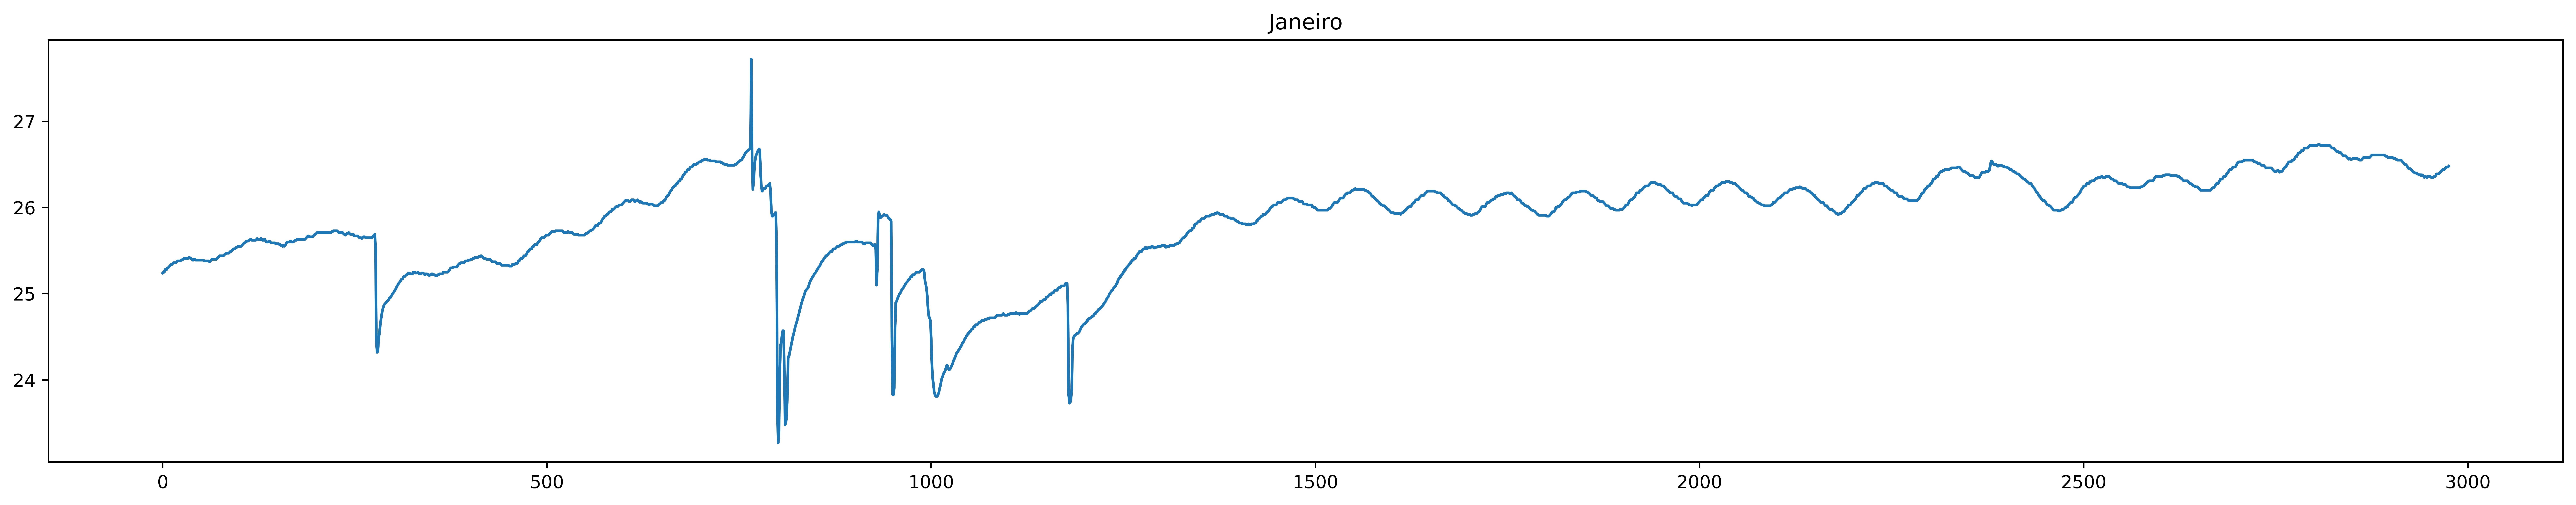

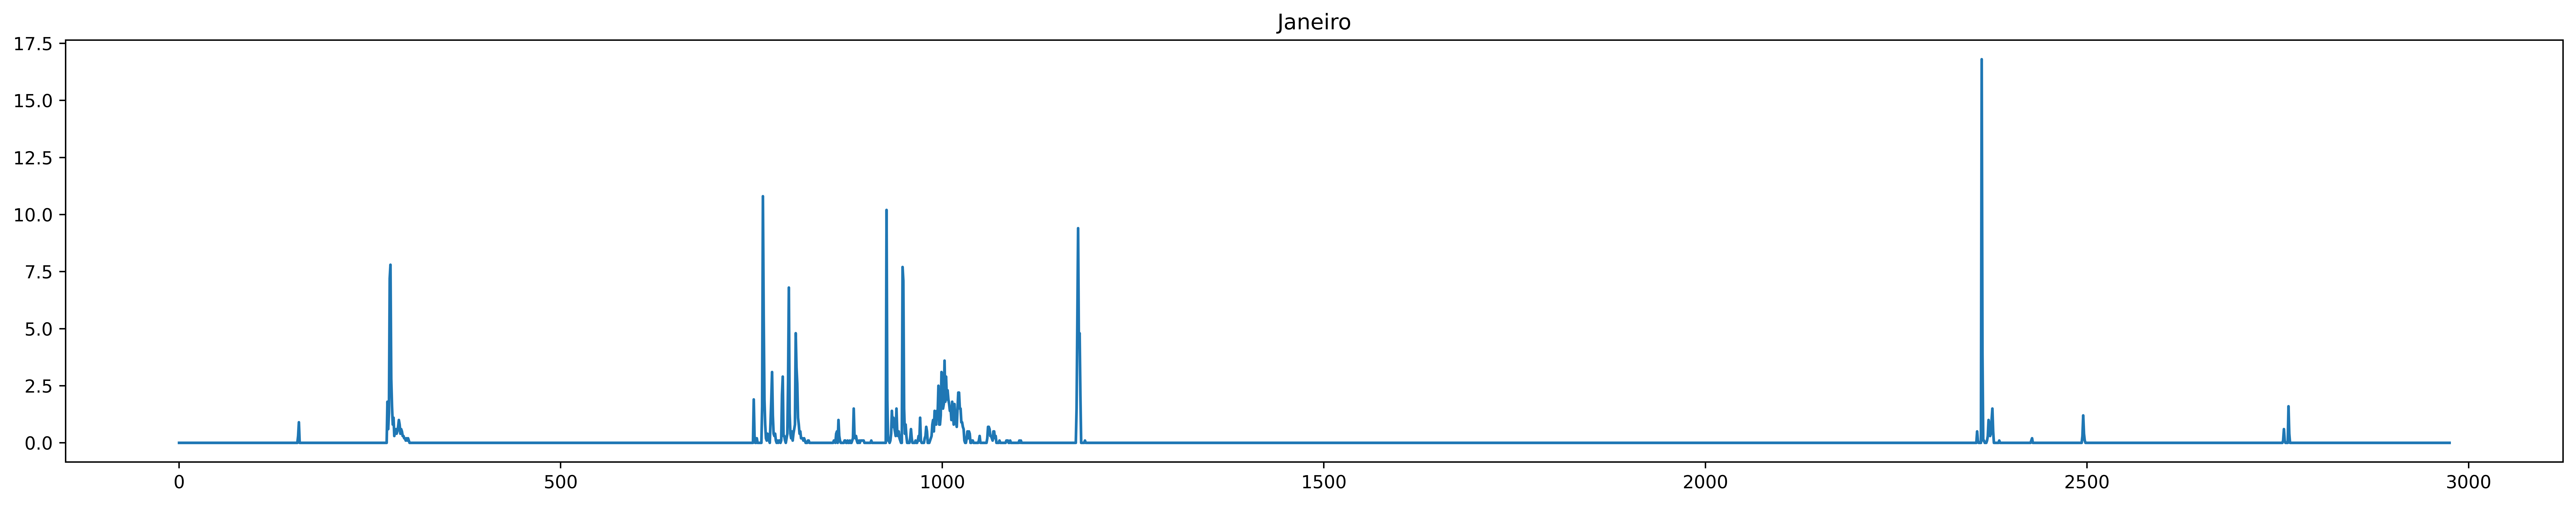

In [198]:
stl_input = pd.read_csv(series_file)
meses_jan = [{'tempsolocm40cm': mes[1]['tempsolocm40cm'], 'prec': mes[1]['prec']} for mes in stl_input.groupby(['year'])]
plot(meses_jan[0]['tempsolocm40cm'].to_list(), sec_plots=[meses_jan[0]['prec'].to_list()], title='Janeiro')

plot(meses_jan[0]['tempsolocm40cm'].to_list(), title='Janeiro')
plot(meses_jan[0]['prec'].to_list(), title='Janeiro')

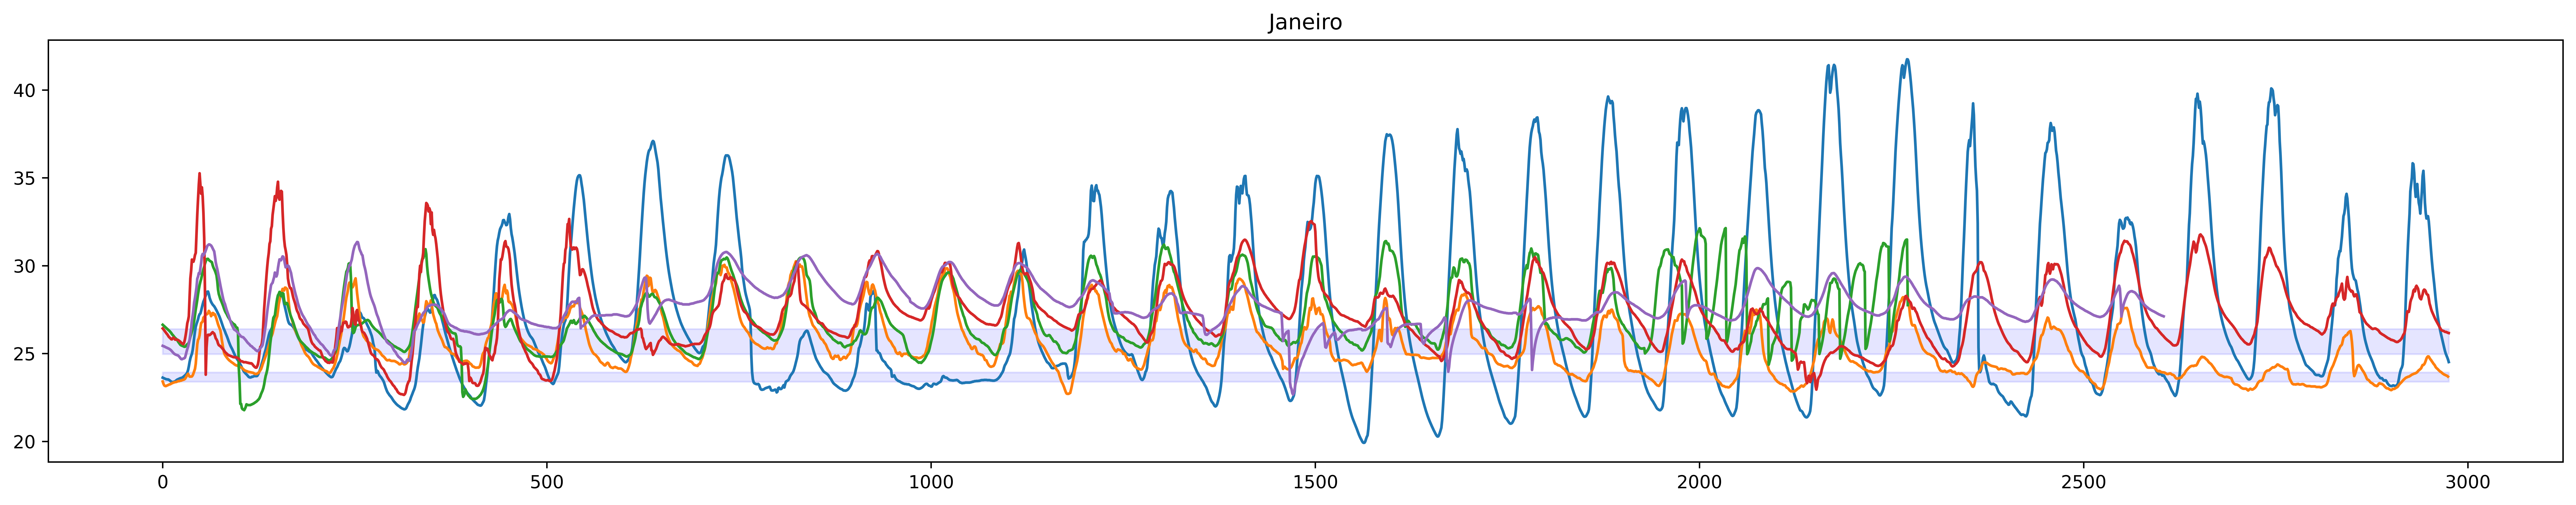

In [205]:
plot(meses_jan[0].to_list(), sec_plots=[m.to_list() for m in meses_jan[1:]], margins=aplies, title='Janeiro')

In [ ]:
img_name = 'prec.tempsolocm40cm.{}.dia_id.mes_1'.format(station_id, mes)
series_name = 'prec.tempsolocm40cm.{}.dia_id.mes_1.csv'.format(station_id, mes)
grammar = 'grammar_idr.bnf'
series_file = './data/meses/{}'.format(series_name)
output_file = './output/{}'.format(series_name)
best_regras = pd.read_csv(output_file)
series = pd.read_csv(series_file)

# Tirando regras que não usam a temperatura
# regras = [regra for regra in regras if regra.find(data_name) >= 0]
# eval_regras = []
regra = best_regras.iloc[-1]
function = parse_rule(regra['serialized'])
id_linhas = []
for i, serie in series.iterrows():
	if function(serie) < 0:
		id_linhas.append(i)
cont = sep_anomalies(id_linhas)
plot(series[data_name], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=True, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [ ]:
for mes in meses:
	for esparso in [False, True]:
		if esparso:
			img_name = '{}.{}.dia_id.mes_{}.esparso'.format(data_name, station_id, mes)
			series_name = '{}.{}.dia_id.mes_{}.esparso.csv'.format(data_name, station_id, mes)
			grammar = 'grammar_idr_esparso.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		else:
			img_name = '{}.{}.dia_id.mes_{}'.format(data_name, station_id, mes)
			series_name = '{}.{}.dia_id.mes_{}.csv'.format(data_name, station_id, mes)
			grammar = 'grammar_idr.bnf'
			series_file = './data/meses/{}'.format(series_name)
			output_file = './output/{}'.format(series_name)
		best_regras = pd.read_csv(output_file)
		series = pd.read_csv(series_file)
	
		# Tirando regras que não usam a temperatura
		# regras = [regra for regra in regras if regra.find(data_name) >= 0]
		# eval_regras = []
		regra = best_regras.iloc[-1]
		function = parse_rule(regra['serialized'])
		id_linhas = []
		for i, serie in series.iterrows():
			if function(serie) < 0:
				id_linhas.append(i)
		cont = sep_anomalies(id_linhas)
		plot(series[data_name], continuous_anomalies=cont, title='{}, {}'.format(regra['serialized'], regra['best.fitness.value']), save=True, show=False, img_name='./output/imagens/{}_{}.jpg'.format(img_name, regra['best.fitness.value']))

In [ ]:
pd.read_csv('./data/meses/tempsolocm2cm.23025122.dia_id.mes_1.csv').head()

In [ ]:
plot(pd.read_csv('./data/meses/tempsolocm2cm.23025122.dia_id.mes_1.csv')['tempsolocm2cm'], save=True, img_name='img.jpg')